<a href="https://colab.research.google.com/github/sanky2501/EDI-SEM-3/blob/master/EDI_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Simple Algoithm

In [0]:
import numpy as np
import pandas as pd
import featuretools as ft
from sklearn import metrics

In [0]:
data_path = 'https://raw.githubusercontent.com/sanky2501/EDI-SEM-3/master/CMAPSSData/train_FD004.txt'

operational_settings = ['operational_setting_{}'.format(i + 1) for i in range (3)]
sensor_columns = ['sensor_measurement_{}'.format(i + 1) for i in range(26)]
cols = ['engine_no', 'time_in_cycles'] + operational_settings + sensor_columns
data = pd.read_csv(data_path, sep=' ', header=None, names=cols)
data = data.drop(cols[-5:], axis=1)
data['index'] = data.index
data.index = data['index']
data['time'] = pd.date_range('1/1/2000', periods=data.shape[0], freq='600s')
print('Loaded data with:\n{} Recordings\n{} Engines'.format(data.shape[0], len(data['engine_no'].unique())))
print('21 Sensor Measurements\n3 Operational Settings')

data.head(10)


Loaded data with:
61249 Recordings
249 Engines
21 Sensor Measurements
3 Operational Settings


,engine_no,time_in_cycles,operational_setting_1,operational_setting_2,operational_setting_3,sensor_measurement_1,sensor_measurement_2,sensor_measurement_3,sensor_measurement_4,sensor_measurement_5,sensor_measurement_6,sensor_measurement_7,sensor_measurement_8,sensor_measurement_9,sensor_measurement_10,sensor_measurement_11,sensor_measurement_12,sensor_measurement_13,sensor_measurement_14,sensor_measurement_15,sensor_measurement_16,sensor_measurement_17,sensor_measurement_18,sensor_measurement_19,sensor_measurement_20,sensor_measurement_21,index,time
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1,1,42.0049,0.8400,100.0,445.00,549.68,1343.43,1112.93,3.91,5.70,137.36,2211.86,8311.32,1.01,41.69,129.78,2387.99,8074.83,9.3335,0.02,330,2212,100.00,10.62,6.3670,0,2000-01-01 00:00:00
1,1,2,20.0020,0.7002,100.0,491.19,606.07,1477.61,1237.50,9.35,13.61,332.10,2323.66,8713.60,1.07,43.94,312.59,2387.73,8046.13,9.1913,0.02,361,2324,100.00,24.37,14.6552,1,2000-01-01 00:10:00
2,1,3,42.0038,0.8409,100.0,445.00,548.95,1343.12,1117.05,3.91,5.69,138.18,2211.92,8306.69,1.01,41.66,129.62,2387.97,8066.62,9.4007,0.02,329,2212,100.00,10.48,6.4213,2,2000-01-01 00:20:00
3,1,4,42.0000,0.8400,100.0,445.00,548.70,1341.24,1118.03,3.91,5.70,137.98,2211.88,8312.35,1.02,41.68,129.80,2388.02,8076.05,9.3369,0.02,328,2212,100.00,10.54,6.4176,3,2000-01-01 00:30:00
4,1,5,25.0063,0.6207,60.0,462.54,536.10,1255.23,1033.59,7.05,9.00,174.82,1915.22,7994.94,0.93,36.48,164.11,2028.08,7865.80,10.8366,0.02,305,1915,84.93,14.03,8.6754,4,2000-01-01 00:40:00
5,1,6,34.9996,0.8400,100.0,449.44,554.77,1352.87,1117.01,5.48,7.97,193.82,2222.77,8340.00,1.02,41.44,181.90,2387.87,8054.10,9.3346,0.02,330,2223,100.00,14.91,8.9057,5,2000-01-01 00:50:00
6,1,7,0.0019,0.0001,100.0,518.67,641.83,1583.47,1393.89,14.62,21.58,552.45,2387.92,9050.50,1.30,46.94,520.48,2387.89,8127.92,8.3960,0.03,391,2388,100.00,38.93,23.4578,6,2000-01-01 01:00:00
7,1,8,41.9981,0.8400,100.0,445.00,549.05,1344.16,1110.77,3.91,5.69,137.13,2211.92,8307.28,1.01,41.60,129.65,2387.97,8075.99,9.3679,0.02,329,2212,100.00,10.55,6.2787,7,2000-01-01 01:10:00
8,1,9,42.0016,0.8400,100.0,445.00,549.55,1342.85,1101.67,3.91,5.70,138.02,2211.90,8307.81,1.02,41.44,129.65,2388.00,8071.13,9.3384,0.02,328,2212,100.00,10.63,6.3055,8,2000-01-01 01:20:00


In [0]:
from random import randint

def new_labels(data, labels):
    ct_ids = []
    ct_times = []
    ct_labels = []
    data = data.copy()
    data['RUL'] = labels
    gb = data.groupby(['engine_no'])
    for engine_no_df in gb:
        instances = engine_no_df[1].shape[0]
        r = randint(5, instances - 1)
        ct_ids.append(engine_no_df[1].iloc[r,:]['engine_no'])
        ct_times.append(engine_no_df[1].iloc[r,:]['time'])
        ct_labels.append(engine_no_df[1].iloc[r,:]['RUL'])
    ct = pd.DataFrame({'engine_no': ct_ids,
                       'cutoff_time': ct_times,
                       'RUL': ct_labels})
    ct = ct[['engine_no', 'cutoff_time', 'RUL']]
    ct.index = ct['engine_no']
    ct.index = ct.index.rename('index')
    return ct

def make_cutoff_times(data):
    gb = data.groupby(['engine_no'])
    labels = []


    for engine_no_df in gb:
        instances = engine_no_df[1].shape[0]
        label = [instances - i - 1 for i in range(instances)]
        labels += label
    
    return new_labels(data, labels)

cutoff_times = make_cutoff_times(data)

cutoff_times.head()

,engine_no,cutoff_time,RUL
index,,,
1,1,2000-01-02 00:50:00,171
2,2,2000-01-04 01:50:00,176
3,3,2000-01-06 07:30:00,161
4,4,2000-01-07 18:00:00,228
5,5,2000-01-09 13:40:00,159


In [0]:
def make_entityset(dataset):
    es = ft.EntitySet('Dataset')
    es.entity_from_dataframe(dataframe=dataset,
                             entity_id='recordings',
                             index='index',
                             time_index='time')

    es.normalize_entity(base_entity_id='recordings', 
                        new_entity_id='engines',
                        index='engine_no')

    es.normalize_entity(base_entity_id='recordings', 
                        new_entity_id='cycles',
                        index='time_in_cycles')
    return es
es = make_entityset(data)
es

Entityset: Dataset
  Entities:
    recordings [Rows: 61249, Columns: 28]
    engines [Rows: 249, Columns: 2]
    cycles [Rows: 543, Columns: 2]
  Relationships:
    recordings.engine_no -> engines.engine_no
    recordings.time_in_cycles -> cycles.time_in_cycles

In [0]:
fm, features = ft.dfs(entityset=es, 
                      target_entity='engines',
                      agg_primitives=['last', 'max', 'min'],
                      trans_primitives=[],
                      cutoff_time=cutoff_times,
                      max_depth=3,
                      verbose=True)
fm.to_csv('simple_fm.csv')

Built 290 features
Elapsed: 02:44 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 11/11 chunks


In [0]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

fm = pd.read_csv('simple_fm.csv', index_col='engine_no')
X = fm.copy().fillna(0)
y = X.pop('RUL')

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=17)

In [0]:
medianpredict1 = [np.median(y_train) for _ in y_test]
print('Baseline by median label: Mean Abs Error = {:.2f}'.format(
    mean_absolute_error(medianpredict1, y_test)))

Baseline by median label: Mean Abs Error = 69.58


In [0]:
recordings_from_train = es['recordings'].df[es['recordings'].df['engine_no'].isin(y_train.index)]
median_life = np.median(recordings_from_train.groupby(['engine_no']).apply(lambda df: df.shape[0]))

recordings_from_test = es['recordings'].df[es['recordings'].df['engine_no'].isin(y_test.index)]
life_in_test = recordings_from_test.groupby(['engine_no']).apply(lambda df: df.shape[0])-y_test

medianpredict2 = (median_life - life_in_test).apply(lambda row: max(row, 0))
print('Baseline by median life: Mean Abs Error = {:.2f}'.format(
    mean_absolute_error(medianpredict2, y_test)))

Baseline by median life: Mean Abs Error = 90.59


Random Forest Regressor

In [0]:
reg = RandomForestRegressor(n_estimators=100)
reg.fit(X_train, y_train)

#preds = reg.predict(X_test)
y_pred = pd.DataFrame()   # dataframe for predictions vs actual y-values
y_pred['predictions'] = reg.predict(X_test)
#scores = mean_absolute_error(preds, y_test)
#print('Mean Abs Error: {:.2f}'.format(scores))
#high_imp_feats = utils.feature_importances(X, reg, feats=10)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  

Mean Absolute Error: 38.988253968253964


Data_1 for plotting importances

In [0]:
data_1 = data.drop(["engine_no"],axis=1,inplace=False)
data_1.drop(["time_in_cycles"],axis=1,inplace=True)
data_1.drop(["index"],axis=1,inplace=True)
data_1.drop(["time"],axis=1,inplace=True)

data_1.head(10)

,operational_setting_1,operational_setting_2,operational_setting_3,sensor_measurement_1,sensor_measurement_2,sensor_measurement_3,sensor_measurement_4,sensor_measurement_5,sensor_measurement_6,sensor_measurement_7,sensor_measurement_8,sensor_measurement_9,sensor_measurement_10,sensor_measurement_11,sensor_measurement_12,sensor_measurement_13,sensor_measurement_14,sensor_measurement_15,sensor_measurement_16,sensor_measurement_17,sensor_measurement_18,sensor_measurement_19,sensor_measurement_20,sensor_measurement_21
index,,,,,,,,,,,,,,,,,,,,,,,,
0,42.0049,0.8400,100.0,445.00,549.68,1343.43,1112.93,3.91,5.70,137.36,2211.86,8311.32,1.01,41.69,129.78,2387.99,8074.83,9.3335,0.02,330,2212,100.00,10.62,6.3670
1,20.0020,0.7002,100.0,491.19,606.07,1477.61,1237.50,9.35,13.61,332.10,2323.66,8713.60,1.07,43.94,312.59,2387.73,8046.13,9.1913,0.02,361,2324,100.00,24.37,14.6552
2,42.0038,0.8409,100.0,445.00,548.95,1343.12,1117.05,3.91,5.69,138.18,2211.92,8306.69,1.01,41.66,129.62,2387.97,8066.62,9.4007,0.02,329,2212,100.00,10.48,6.4213
3,42.0000,0.8400,100.0,445.00,548.70,1341.24,1118.03,3.91,5.70,137.98,2211.88,8312.35,1.02,41.68,129.80,2388.02,8076.05,9.3369,0.02,328,2212,100.00,10.54,6.4176
4,25.0063,0.6207,60.0,462.54,536.10,1255.23,1033.59,7.05,9.00,174.82,1915.22,7994.94,0.93,36.48,164.11,2028.08,7865.80,10.8366,0.02,305,1915,84.93,14.03,8.6754
5,34.9996,0.8400,100.0,449.44,554.77,1352.87,1117.01,5.48,7.97,193.82,2222.77,8340.00,1.02,41.44,181.90,2387.87,8054.10,9.3346,0.02,330,2223,100.00,14.91,8.9057
6,0.0019,0.0001,100.0,518.67,641.83,1583.47,1393.89,14.62,21.58,552.45,2387.92,9050.50,1.30,46.94,520.48,2387.89,8127.92,8.3960,0.03,391,2388,100.00,38.93,23.4578
7,41.9981,0.8400,100.0,445.00,549.05,1344.16,1110.77,3.91,5.69,137.13,2211.92,8307.28,1.01,41.60,129.65,2387.97,8075.99,9.3679,0.02,329,2212,100.00,10.55,6.2787
8,42.0016,0.8400,100.0,445.00,549.55,1342.85,1101.67,3.91,5.70,138.02,2211.90,8307.81,1.02,41.44,129.65,2388.00,8071.13,9.3384,0.02,328,2212,100.00,10.63,6.3055


In [0]:
feature_list = list(data_1.columns)
# Get numerical feature importances
importances = list(reg.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]

Variable: operational_setting_1 Importance: 0.02
Variable: operational_setting_2 Importance: 0.0
Variable: operational_setting_3 Importance: 0.0
Variable: sensor_measurement_1 Importance: 0.0
Variable: sensor_measurement_2 Importance: 0.0
Variable: sensor_measurement_3 Importance: 0.0
Variable: sensor_measurement_4 Importance: 0.0
Variable: sensor_measurement_5 Importance: 0.0
Variable: sensor_measurement_6 Importance: 0.0
Variable: sensor_measurement_7 Importance: 0.0
Variable: sensor_measurement_8 Importance: 0.0
Variable: sensor_measurement_9 Importance: 0.0
Variable: sensor_measurement_10 Importance: 0.0
Variable: sensor_measurement_11 Importance: 0.0
Variable: sensor_measurement_12 Importance: 0.0
Variable: sensor_measurement_13 Importance: 0.0
Variable: sensor_measurement_14 Importance: 0.0
Variable: sensor_measurement_15 Importance: 0.0
Variable: sensor_measurement_16 Importance: 0.0
Variable: sensor_measurement_17 Importance: 0.0
Variable: sensor_measurement_18 Importance: 0.0


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

Histograms

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f295bf702b0>,
      dtype=object)

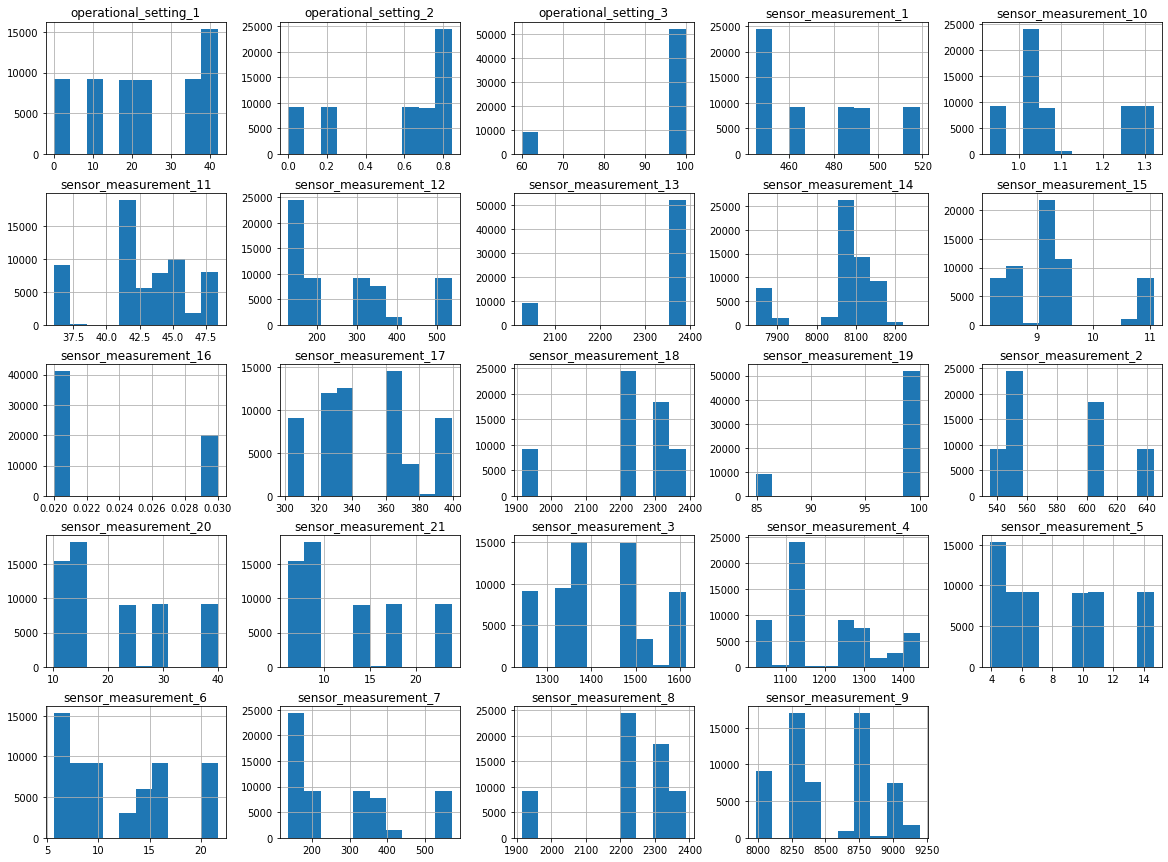

In [0]:
# Plotting Histograms to observe frequencies
data_1.hist(figsize=[20,15])

Loading Test Dataset

In [0]:
def load_data(data_path):
    operational_settings = ['operational_setting_{}'.format(i + 1) for i in range (3)]
    sensor_columns = ['sensor_measurement_{}'.format(i + 1) for i in range(26)]
    cols = ['engine_no', 'time_in_cycles'] + operational_settings + sensor_columns
    data = pd.read_csv(data_path, sep=' ', header=None, names=cols)
    data = data.drop(cols[-5:], axis=1)
    data['index'] = data.index
    data.index = data['index']
    data['time'] = pd.date_range('1/1/2000', periods=data.shape[0], freq='600s')
    print('Loaded data with:\n{} Recordings\n{} Engines'.format(data.shape[0], len(data['engine_no'].unique())))
    print('21 Sensor Measurements\n3 Operational Settings')
    return data

data_path = 'https://raw.githubusercontent.com/sanky2501/EDI-SEM-3/master/CMAPSSData/test_FD004.txt'

data_test = load_data(data_path)
data_test.head(10)



Loaded data with:
41214 Recordings
248 Engines
21 Sensor Measurements
3 Operational Settings


,engine_no,time_in_cycles,operational_setting_1,operational_setting_2,operational_setting_3,sensor_measurement_1,sensor_measurement_2,sensor_measurement_3,sensor_measurement_4,sensor_measurement_5,sensor_measurement_6,sensor_measurement_7,sensor_measurement_8,sensor_measurement_9,sensor_measurement_10,sensor_measurement_11,sensor_measurement_12,sensor_measurement_13,sensor_measurement_14,sensor_measurement_15,sensor_measurement_16,sensor_measurement_17,sensor_measurement_18,sensor_measurement_19,sensor_measurement_20,sensor_measurement_21,index,time
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1,1,20.0072,0.7000,100.0,491.19,606.67,1481.04,1227.81,9.35,13.60,332.52,2323.67,8704.98,1.07,43.83,313.03,2387.78,8048.98,9.2229,0.02,362,2324,100.00,24.31,14.7007,0,2000-01-01 00:00:00
1,1,2,24.9984,0.6200,60.0,462.54,536.22,1256.17,1031.48,7.05,9.00,174.46,1915.21,7999.94,0.93,36.11,163.61,2028.09,7863.46,10.8632,0.02,306,1915,84.93,14.36,8.5748,1,2000-01-01 00:10:00
2,1,3,42.0000,0.8420,100.0,445.00,549.23,1340.13,1105.88,3.91,5.69,137.34,2211.93,8305.38,1.01,41.52,129.98,2387.95,8071.13,9.3960,0.02,328,2212,100.00,10.39,6.4365,2,2000-01-01 00:20:00
3,1,4,42.0035,0.8402,100.0,445.00,549.19,1339.70,1107.26,3.91,5.69,137.23,2211.89,8301.00,1.01,41.73,129.48,2387.90,8078.89,9.3594,0.02,328,2212,100.00,10.56,6.2367,3,2000-01-01 00:30:00
4,1,5,35.0079,0.8400,100.0,449.44,555.10,1353.04,1117.80,5.48,7.97,192.94,2222.71,8331.05,1.02,41.32,181.82,2387.87,8057.83,9.3030,0.02,333,2223,100.00,14.85,8.9326,4,2000-01-01 00:40:00
5,1,6,25.0010,0.6203,60.0,462.54,536.40,1255.38,1043.74,7.05,9.00,174.32,1915.27,8001.14,0.93,36.41,163.95,2028.12,7867.38,10.8661,0.02,304,1915,84.93,14.17,8.6135,5,2000-01-01 00:50:00
6,1,7,19.9996,0.7015,100.0,491.19,607.29,1473.03,1230.62,9.35,13.60,332.63,2323.64,8708.79,1.07,43.94,312.77,2387.83,8052.97,9.1925,0.02,362,2324,100.00,24.52,14.6965,6,2000-01-01 01:00:00
7,1,8,35.0015,0.8414,100.0,449.44,554.81,1361.07,1115.14,5.48,7.97,193.45,2222.76,8328.97,1.02,41.39,182.23,2387.84,8055.81,9.3004,0.02,331,2223,100.00,14.84,8.9004,7,2000-01-01 01:10:00
8,1,9,19.9980,0.7000,100.0,491.19,607.35,1481.89,1240.15,9.35,13.60,332.27,2323.66,8705.64,1.07,43.79,312.20,2387.76,8052.46,9.1965,0.02,362,2324,100.00,24.34,14.6079,8,2000-01-01 01:20:00


In [0]:
es2 = make_entityset(data_test)
fm2 = ft.calculate_feature_matrix(entityset=es2, features=features, verbose=True)
fm2.head()

Elapsed: 00:10 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 11/11 chunks


,LAST(recordings.time_in_cycles),LAST(recordings.operational_setting_1),LAST(recordings.operational_setting_2),LAST(recordings.operational_setting_3),LAST(recordings.sensor_measurement_1),LAST(recordings.sensor_measurement_2),LAST(recordings.sensor_measurement_3),LAST(recordings.sensor_measurement_4),LAST(recordings.sensor_measurement_5),LAST(recordings.sensor_measurement_6),LAST(recordings.sensor_measurement_7),LAST(recordings.sensor_measurement_8),LAST(recordings.sensor_measurement_9),LAST(recordings.sensor_measurement_10),LAST(recordings.sensor_measurement_11),LAST(recordings.sensor_measurement_12),LAST(recordings.sensor_measurement_13),LAST(recordings.sensor_measurement_14),LAST(recordings.sensor_measurement_15),LAST(recordings.sensor_measurement_16),LAST(recordings.sensor_measurement_17),LAST(recordings.sensor_measurement_18),LAST(recordings.sensor_measurement_19),LAST(recordings.sensor_measurement_20),LAST(recordings.sensor_measurement_21),MAX(recordings.operational_setting_1),MAX(recordings.operational_setting_2),MAX(recordings.operational_setting_3),MAX(recordings.sensor_measurement_1),MAX(recordings.sensor_measurement_2),MAX(recordings.sensor_measurement_3),MAX(recordings.sensor_measurement_4),MAX(recordings.sensor_measurement_5),MAX(recordings.sensor_measurement_6),MAX(recordings.sensor_measurement_7),MAX(recordings.sensor_measurement_8),MAX(recordings.sensor_measurement_9),MAX(recordings.sensor_measurement_10),MAX(recordings.sensor_measurement_11),MAX(recordings.sensor_measurement_12),...,MIN(recordings.cycles.MAX(recordings.sensor_measurement_6)),MIN(recordings.cycles.MAX(recordings.sensor_measurement_7)),MIN(recordings.cycles.MAX(recordings.sensor_measurement_8)),MIN(recordings.cycles.MAX(recordings.sensor_measurement_9)),MIN(recordings.cycles.MAX(recordings.sensor_measurement_10)),MIN(recordings.cycles.MAX(recordings.sensor_measurement_11)),MIN(recordings.cycles.MAX(recordings.sensor_measurement_12)),MIN(recordings.cycles.MAX(recordings.sensor_measurement_13)),MIN(recordings.cycles.MAX(recordings.sensor_measurement_14)),MIN(recordings.cycles.MAX(recordings.sensor_measurement_15)),MIN(recordings.cycles.MAX(recordings.sensor_measurement_16)),MIN(recordings.cycles.MAX(recordings.sensor_measurement_17)),MIN(recordings.cycles.MAX(recordings.sensor_measurement_18)),MIN(recordings.cycles.MAX(recordings.sensor_measurement_19)),MIN(recordings.cycles.MAX(recordings.sensor_measurement_20)),MIN(recordings.cycles.MAX(recordings.sensor_measurement_21)),MIN(recordings.cycles.MIN(recordings.operational_setting_1)),MIN(recordings.cycles.MIN(recordings.operational_setting_2)),MIN(recordings.cycles.MIN(recordings.operational_setting_3)),MIN(recordings.cycles.MIN(recordings.sensor_measurement_1)),MIN(recordings.cycles.MIN(recordings.sensor_measurement_2)),MIN(recordings.cycles.MIN(recordings.sensor_measurement_3)),MIN(recordings.cycles.MIN(recordings.sensor_measurement_4)),MIN(recordings.cycles.MIN(recordings.sensor_measurement_5)),MIN(recordings.cycles.MIN(recordings.sensor_measurement_6)),MIN(recordings.cycles.MIN(recordings.sensor_measurement_7)),MIN(recordings.cycles.MIN(recordings.sensor_measurement_8)),MIN(recordings.cycles.MIN(recordings.sensor_measurement_9)),MIN(recordings.cycles.MIN(recordings.sensor_measurement_10)),MIN(recordings.cycles.MIN(recordings.sensor_measurement_11)),MIN(recordings.cycles.MIN(recordings.sensor_measurement_12)),MIN(recordings.cycles.MIN(recordings.sensor_measurement_13)),MIN(recordings.cycles.MIN(recordings.sensor_measurement_14)),MIN(recordings.cycles.MIN(recordings.sensor_measurement_15)),MIN(recordings.cycles.MIN(recordings.sensor_measurement_16)),MIN(recordings.cycles.MIN(recordings.sensor_measurement_17)),MIN(recordings.cycles.MIN(recordings.sensor_measurement_18)),MIN(recordings.cycles.MIN(recordings.sensor_measurement_19)),MIN(recordings.cycles.MIN(recordings.sensor_measurement_20)),MIN(recordings.cycles.MIN(recordings.sensor_measurement_21))
engine_no,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,

Loading RUL dataset 

In [0]:
x_new = fm2.copy().fillna(0)
y_new = pd.read_csv('https://raw.githubusercontent.com/sanky2501/EDI-SEM-3/master/CMAPSSData/RUL_FD004.txt', sep=' ', header=None, names=['RUL'], index_col=False)
preds2 = reg.predict(x)
print('Mean Abs Error: {:.2f}'.format(mean_absolute_error(preds2, y)))
y_new.head()

Mean Abs Error: 45.45


,RUL
0,22
1,39
2,107
3,75
4,149


Calculating Mean Absolute error and Total Error

In [0]:
y_ = pd.DataFrame()
y_ = pd.concat([y_,y_new],axis=1)
y_['prediction'] = reg.predict(x)
y_['error'] = y_['prediction'] - y_['RUL']
y_['total'] = y_['error'].sum()
y_['Mean_abs_error'] = y_['total']/249
y_.head(10)     

,RUL,prediction,error,total,Mean_abs_error
0,22,124.91,102.91,8505.51,34.158675
1,39,106.26,67.26,8505.51,34.158675
2,107,151.82,44.82,8505.51,34.158675
3,75,135.38,60.38,8505.51,34.158675
4,149,146.41,-2.59,8505.51,34.158675
5,78,147.40,69.40,8505.51,34.158675
6,94,146.86,52.86,8505.51,34.158675
7,14,40.85,26.85,8505.51,34.158675
8,99,95.69,-3.31,8505.51,34.158675
9,162,200.01,38.01,8505.51,34.158675


Calculating Score

In [0]:
for i,j in y_.iterrows()
    